### This script allows to load OLR data, detect cloud bands and then do the inheritance tracking

In [22]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, ConnectionPatch
from matplotlib.ticker import MultipleLocator

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")
from skimage import measure


import os
import warnings
warnings.filterwarnings('ignore')

from cloudbandpy.load_driver import run_load_data

from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.io_utilities import create_list_of_dates, load_ymlfile, add_startend_datetime2config
from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.tracking import tracking, findCloud
from cloudbandpy.misc import wrapTo180


Load configuration file and make adjustements for this test case

In [23]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Make sure that the period for the cloud bands cover the same period as the example data
config_event["startdate"] = "20160417.00"
config_event["enddate"] = "20160420.00"

dirdata = "data/"
config_event["clouddata_path"] = os.path.join(base_dir, "data")
config_event["parameters_file"] = os.path.join(
    base_dir, "parameters/parameters_southhemisphere.yml"
)
# No need to save any files
config_event["load_saved_files"] = False
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

# filepath = f"{config['saved_dirpath']}list_of_cloud_bands"+config['startdate']+"-"+config['enddate']+"-"+config['domain']+".bin"
# print("Example data exists:", os.path.isfile(filepath))
# print("file is:", filepath)
print(config)

2024-01-04 11:18:08,491 - io_utilities.load_ymlfile - INFO: Configuration file loaded


{'run_inheritance_tracking': True, 'startdate': '20160101.00', 'enddate': '20160130.00', 'domain': 'southPacific', 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50, 'clouddata_path': './ERA5/netcdf/3hourly/surface_level/', 'varname_infilename': 'top_net_thermal_radiation', 'qd_var': True, 'datatimeresolution': 3.0, 'period_detection': 24.0, 'olr_convert2wm2': True, 'varname': 'ttr', 'timecoord_name': 'time', 'xcoord_name': 'longitude', 'ycoord_name': 'latitude', 'select_djfm': False, 'parameters_file': './cloudbandPy/parameters/parameters_southhemisphere.yml', 'saved_dirpath': './cloud_band_files', 'save_dailyvar': False, 'save_listcloudbands': True, 'load_saved_files': False, 'dir_figures': './cloud_band_figures', 'fig_detection_process': False, 'fig_time_evolution_object': False, 'fig_time_evolution_var_cloudband': False, 'fig_overlay_cloudband': False, 'fig_show_bbox_around_blobs': False, 'fig_inheritance_tracking': False, 'fig_density': Fals

Get OLR on 3-hourly data (one hour mean from ERA5)

In [41]:
config_event["qd_var"] = False
olr2process, parameters, lats, lons, _ = run_load_data(config_event)

2024-01-04 11:21:54,618 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-01-04 11:21:54,645 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-01-04 11:21:54,647 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-01-04 11:21:54,647 - io_utilities.load_dataset - INFO: Loading 2016 --> 2016
2024-01-04 11:21:55,507 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-01-04 11:21:55,510 - io_utilities.load_dataset - INFO: Dataset loaded


In [25]:
#Parameters for plot
lat_north, lat_south = round(lats[0]), round(lats[-1])
major_xticks = np.concatenate((np.arange(0, 180, 30), np.arange(-180, 0, 30)))
minor_xticks = np.concatenate((np.arange(0, 180, 10), np.arange(-180, 0, 10)))

major_yticks = np.arange(-80, 100, 20)
minor_yticks = np.arange(-80, 100, 5)
set_fontsize(16)

Snapshot of OLR data before "smoothing"/daily mean. Date is 2016-04-18 at 06 UTC.

(-50.0, 5.0)

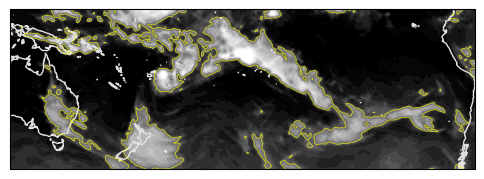

In [50]:
blob_colors = ["#ff474c"]

fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
conto = ax.contourf(
    lons,
    lats,
    olr2process[10],
    transform=ccrs.PlateCarree(),
    levels=range(100, 300, 10),
    cmap="binary",
    extend="both",
)
ax.contour(
    lons,
    lats,
    olr2process[10],
    transform=ccrs.PlateCarree(),
    levels=list([parameters["OLR_THRESHOLD"]]),
    colors="yellow",
    linewidths=0.6,
    alpha=0.7
)

ax.coastlines("50m", color="#E0E0E0")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, 5])

# cax = ax.inset_axes([1.02, 0.0, 0.03, 0.99])
# cbar = fig.colorbar(conto, ax=ax, cax=cax)
# cbar.set_ticks(np.arange(100, 340, 40))
# cbar.set_label(r"OLR (W.m$^{-2}$)")


In [27]:
# We want daily mean
config_event["qd_var"] = True

Load cloud bands from the South Pacific for the dates specified in the analyses config file

In [28]:
add_startend_datetime2config(config_event)
listofdates = create_list_of_dates(config_event)
print(str(len(listofdates))+" dates created from "+str(listofdates[0])+" to "+str(listofdates[-1]))

4 dates created from 2016-04-17 00:00:00 to 2016-04-20 00:00:00


Load data

In [29]:
olr2process, parameters, listofdates, lats, lons, resolution = run_load_data(config_event)

2024-01-04 11:18:18,714 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-01-04 11:18:18,718 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-01-04 11:18:18,720 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-01-04 11:18:18,720 - io_utilities.load_dataset - INFO: Loading 2016 --> 2016
2024-01-04 11:18:19,610 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-01-04 11:18:19,613 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-01-04 11:18:19,734 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-01-04 11:18:19,736 - io_utilities.load_dataset - INFO: Dataset loaded


Run detection

In [30]:
(
    fill_binarize_data,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_map,
    list_of_candidates,
    list_of_cloud_bands,
) = detection_workflow(
    var2process=olr2process,
    parameters=parameters,
    latitudes=lats,
    longitudes=lons,
    resolution=resolution,
    listofdates=listofdates,
    config=config,
)

2024-01-04 11:18:19,772 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-01-04 11:18:20,218 - cb_detection.detection_workflow - INFO: Cloud band detection done


Get life cycle of each cloud band

In [31]:
list_of_cloud_bands = tracking(list_of_cloud_bands, resolution, overlapfactor=parameters["othresh"])

2024-01-04 11:18:20,226 - cloudbandpy.tracking - INFO: Inheritance tracking in progress
2024-01-04 11:18:20,228 - cloudbandpy.tracking - INFO: Inheritance tracking done


Set variables for plots

In [32]:
olr2process2show = olr2process[1]
fill_binarize_data2show = fill_binarize_data[1]
dilation2show = dilation[1]
labelled_blobs2show = labelled_blobs[1]
labelled_candidates2show = labelled_candidates[1]
cloud_bands_map2show = cloud_bands_map[1]
list_of_candidates2show = list_of_candidates[1]
list_of_cloud_bands2show = list_of_cloud_bands[1]

In [33]:
set_fontsize(12)

OLR + smoothing + Threshold

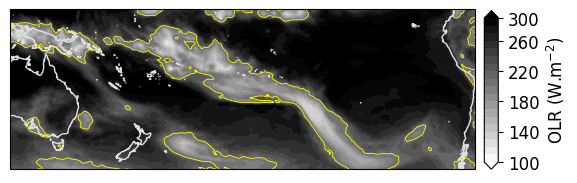

In [34]:
blob_colors = ["#ff474c"]

fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
conto = ax.contourf(
    lons,
    lats,
    olr2process2show,
    transform=ccrs.PlateCarree(),
    levels=range(100, 300, 10),
    cmap="binary",
    extend="both",
)
ax.contour(
    lons,
    lats,
    olr2process2show,
    transform=ccrs.PlateCarree(),
    levels=list([parameters["OLR_THRESHOLD"]]),
    colors="yellow",
    linewidths=0.6,
)
# ax.set_title(r"OLR (W.m$^{-2}$) + threshold", loc="left", fontsize=11)

# ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
# ax.set_yticks(minor_yticks, minor=True)
# ax.yaxis.set_major_formatter(LAT_FORMAT)
# ax.tick_params(axis='y', which='minor', labelleft=False)

# ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
# ax.set_xticks(minor_xticks, minor=True)
# ax.xaxis.set_major_formatter(LON_FORMAT)

ax.coastlines("50m", color="#E0E0E0")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])

cax = ax.inset_axes([1.02, 0.0, 0.03, 0.99])
cbar = fig.colorbar(conto, ax=ax, cax=cax)
cbar.set_ticks(np.arange(100, 340, 40))
cbar.set_label(r"OLR (W.m$^{-2}$)")


Binarization

(-50.0, 5.0)

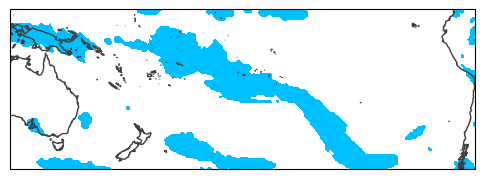

In [35]:
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
conto = ax.contourf(
    lons,
    lats,
    np.ma.masked_where(fill_binarize_data2show == 0, fill_binarize_data2show),
    transform=ccrs.PlateCarree(),
    colors="deepskyblue",
)
# ax.set_title(r"Binarization", loc="left", fontsize=11)

# ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
# ax.set_yticks(minor_yticks, minor=True)
# ax.yaxis.set_major_formatter(LAT_FORMAT)
# ax.tick_params(axis='y', which='minor', labelleft=False)

# ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
# ax.set_xticks(minor_xticks, minor=True)
# ax.xaxis.set_major_formatter(LON_FORMAT)

ax.coastlines("50m", color="#404040")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])

Morphological dilation

(-50.0, 5.0)

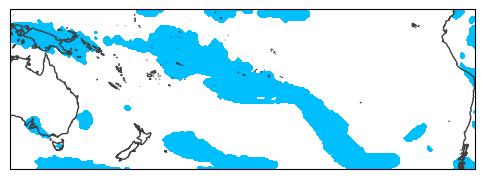

In [36]:
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
conto = ax.contourf(
    lons,
    lats,
    np.ma.masked_where(dilation2show == 0, dilation2show),
    transform=ccrs.PlateCarree(),
    colors="deepskyblue",
)
# ax.set_title(r"Dilation", loc="left", fontsize=11)

# ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
# ax.set_yticks(minor_yticks, minor=True)
# ax.yaxis.set_major_formatter(LAT_FORMAT)
# ax.tick_params(axis='y', which='minor', labelleft=False)

# ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
# ax.set_xticks(minor_xticks, minor=True)
# ax.xaxis.set_major_formatter(LON_FORMAT)

ax.coastlines("50m", color="#404040")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])

Labelling

(-50.0, 5.0)

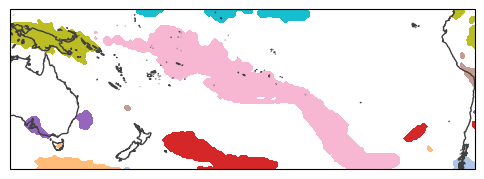

In [37]:
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
conto = ax.contourf(
    lons,
    lats,
    np.ma.masked_where(labelled_blobs2show == 0, labelled_blobs2show),
    transform=ccrs.PlateCarree(),
    cmap="tab20_r",
)
# ax.set_title(r"Labeling", loc="left", fontsize=11)

# ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
# ax.set_yticks(minor_yticks, minor=True)
# ax.yaxis.set_major_formatter(LAT_FORMAT)
# ax.tick_params(axis='y', which='minor', labelleft=False)

# ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
# ax.set_xticks(minor_xticks, minor=True)
# ax.xaxis.set_major_formatter(LON_FORMAT)

ax.coastlines("50m", color="#404040")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])

Properties and cloud band candidates

(-50.0, 5.0)

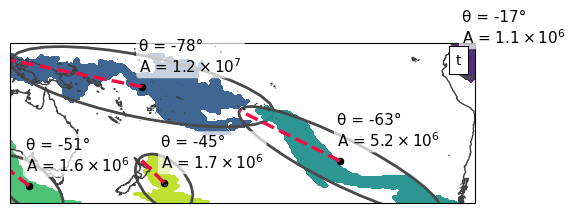

In [38]:
inc=0
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)

for i, cb in enumerate(list_of_candidates[inc]):
    cbmap = (i + 1) * cb.cloud_band_array
    masked_map = np.ma.masked_where(cbmap == 0, cbmap)
    ax.contourf(
        lons,
        lats,
        masked_map,
        transform=ccrs.PlateCarree(),
        levels=range(6),
        alpha=0.95,
        cmap="viridis",
    )
    ax.text(
        0.97,
        0.85,
        f"t",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
        bbox=dict(
            facecolor="white",
            edgecolor="k",
            linewidth=0.7,
            boxstyle="square,pad=0.5",  # Use 'round' as the box style
        ),
        fontsize=10,
    )
    for props in measure.regionprops(cb.cloud_band_array):
        centroid = props.centroid
        x_centroid, y_centroid = (
            lons[int(centroid[1])].item(),
            lats[int(centroid[0])].item(),
        )

        # Extract ellipse properties
        major_axis_length = props.major_axis_length
        minor_axis_length = props.minor_axis_length
        orientation = props.orientation
        angle_deg = (orientation * 360) / (2 * np.pi)

        ax.scatter(
            x_centroid,
            y_centroid,
            color="k",
            marker="o",
            s=20,
            transform=ccrs.PlateCarree(),
        )

        # Create and plot the ellipse with proper orientation
        ellipse = Ellipse(
            (x_centroid, y_centroid),
            width=major_axis_length * 0.5,
            height=minor_axis_length * 0.5,
            angle=angle_deg - 90,
            edgecolor="#494949",
            facecolor="none",
            linewidth=2,
            transform=ccrs.PlateCarree(),
        )
        ax.add_patch(ellipse)

        # Plot major and minor axes using the provided code
        x0, y0 = x_centroid, y_centroid
        x2 = x0 - np.sin(orientation) * 0.25 * major_axis_length
        y2 = y0 + np.cos(orientation) * 0.25 * major_axis_length

        ax.plot(
            (x0, x2),
            (y0, y2),
            "--",
            color="#f10c45",
            linewidth=2.5,
            transform=ccrs.PlateCarree(),
        )
        notation = "{:e}".format(int(cb.area))
        base, exponent = notation.split("e")

        # Get the x and y coordinates of the clicked point
        area_string = rf"${round(float(base), 1)} \times 10^{{{int(exponent)}}}$"
        ax.text(
            x0 - 1,
            y0 + 5,
            f"θ = {-1*int(angle_deg)}°\nA = {area_string}",  # km$^{{2}}$",
            color="k",
            backgroundcolor="white",
            transform=ccrs.PlateCarree(),
            bbox=dict(
                facecolor="white",
                edgecolor="none",
                alpha=0.7,
                boxstyle="round,pad=0.2",
            ),
            fontsize=11,
        )


# ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
# ax.set_yticks(minor_yticks, minor=True)
# ax.yaxis.set_major_formatter(LAT_FORMAT)
# ax.tick_params(axis='y', which='minor', labelleft=False)

# ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
# ax.set_xticks(minor_xticks, minor=True)
# ax.xaxis.set_major_formatter(LON_FORMAT)

ax.coastlines("50m", color="#404040")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])


Cloud bands, IDs and lifecycle tracking

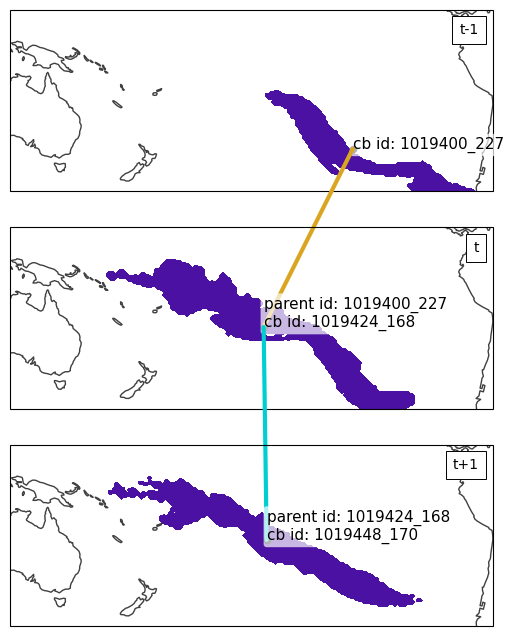

In [39]:
time2showinlegend = ["t-1", "t", "t+1"]

fig, axs = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(13.5, 8),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
colors = [
    "goldenrod",
    "darkturquoise",
    "mediumpurple",
    "darkorange",
    "red",
    "blue",
    "yellowgreen",
]
cid = 0
for inc, ax in enumerate(axs):
    # if inc == 0:
    #     title = ax.set_title(
    #         "b) Cloud bands with their IDs and inheritance", fontsize=12, loc="left"
    #     )
    #     title.set_position([0, 1.05])
    map = list_of_cloud_bands[inc][0].cloud_band_array
    for i, m in enumerate(list_of_cloud_bands[inc][1:]):
        map = map + (i + 2) * m.cloud_band_array
    masked_map = np.ma.masked_where(map == 0, map)
    ax.contourf(
        lons,
        lats,
        masked_map,
        transform=ccrs.PlateCarree(),
        levels=range(6),
        alpha=0.95,
        cmap="plasma",
    )
    ax.text(
        0.97,
        0.85,
        f"{time2showinlegend[inc]}",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
        bbox=dict(
            facecolor="white",
            edgecolor="k",
            linewidth=0.7,
            boxstyle="square,pad=0.5",  # Use 'round' as the box style
        ),
        fontsize=10,
    )

    for ii, cloud in enumerate(list_of_cloud_bands[inc]):
        y0, x0 = cloud.latloncenter
        lon0 = lons[round(x0)]
        lat0 = lats[round(y0)]
        xyA = ccrs.PlateCarree(central_longitude=180).transform_point(
            lon0, lat0, ccrs.PlateCarree()
        )
        ax.scatter(
            lon0,
            lat0,
            color="k",
            marker="o",
            s=20,
            transform=ccrs.PlateCarree(),
        )
        if cloud.parents:
            ax.text(
                lon0,
                lat0,
                f"parent id: {', '.join(str(e.id_) if hasattr(e, 'id_') else str(e) for e in cloud.parents)}\ncb id: {cloud.id_}",
                color="k",
                backgroundcolor="white",
                transform=ccrs.PlateCarree(),
                bbox=dict(
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.7,
                    boxstyle="round,pad=0.2",
                ),
                fontsize=11,
            )
        else:
            ax.text(
                lon0,
                lat0,
                f"cb id: {cloud.id_}",
                color="k",
                backgroundcolor="white",
                transform=ccrs.PlateCarree(),
                bbox=dict(
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.7,
                    boxstyle="round,pad=0.2",
                ),
                fontsize=11,
            )
        for parent_id in cloud.parents:
            parent = findCloud(list_of_cloud_bands, parent_id)
            if parent:
                y1, x1 = parent.latloncenter
                lon1 = lons[round(x1)]
                lat1 = lats[round(y1)]
                xyB = ccrs.PlateCarree(central_longitude=180).transform_point(
                    lon1, lat1, ccrs.PlateCarree()
                )
                con = ConnectionPatch(
                    xyA=xyA,
                    xyB=xyB,
                    coordsA="data",
                    coordsB="data",
                    axesA=ax,
                    axesB=axs[
                        inc - 1
                    ],  # Connect to the previous panel in the same column
                    color=colors[cid % len(colors)],
                    linewidth=3,
                    zorder=2,
                )
                cid += 1
                ax.add_artist(con)



for i, ax in enumerate(axs.ravel()):
    lat_north, lat_south = 10, -50
    lonticks = np.concatenate((np.arange(0, 180, 20), np.arange(-180, 0, 20)))
    latticks = np.arange(-50, 20, 10)
    # ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
    # ax.set_yticks(minor_yticks, minor=True)
    # ax.yaxis.set_major_formatter(LAT_FORMAT)
    # ax.tick_params(axis="y", which="minor", labelleft=False)
    # ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
    # ax.set_xticks(minor_xticks, minor=True)
    # ax.xaxis.set_major_formatter(LON_FORMAT)
    ax.coastlines("110m", color="#404040")
    ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
    ax.set_ylim([lat_south, lat_north])
    original_startdate = config_event["startdate"]
    datetime_obj = dt.datetime.strptime(original_startdate, "%Y%m%d.%H")
    formatted_startdate = datetime_obj.strftime("%Y-%m-%d")
